# TFT Analysis

## Initialization

#### Clear Memory

In [1]:
%reset -f

#### Init

In [ ]:
from utils.file_utils import create_training_directory, create_evaluation_directory, load_config

In [3]:
config_path = 'configs/cds.yaml'
config = load_config(config_path)

In [4]:
data_config = config['data']
time_series_config = config['time_series']
training_config = config['training']
evaluation_config = config['evaluation']
log_config = config['logging']
checkpoint_config = config['checkpoint']

In [5]:
data_root = data_config['data_root']

## Data Pipeline

### Pull dataset from cds api

In [6]:
# import os
# import cdsapi

# # https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

# # Create a directory to save the files
# save_dir = 'data/vietnam_cloud_data'
# # List of selected years
# years = ['2001', '2003', '2005', '2007', '2009', '2011', '2013', '2015', '2017', '2019', '2021', '2023']
# # List of selected months
# months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# # List of selected days
# days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
# # Time intervals for every 2 hours
# times = ['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00']
# # List of variables of interest
# variables = [
#     'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', 'low_cloud_cover',
#     'total_column_cloud_ice_water', 'total_column_cloud_liquid_water'
# ]
# # North, West, South, East coordinates for Vietnam
# vietnam_area = [23, 102, 8, 110]

# # Make saving directory if it doesn't exist
# os.makedirs(save_dir, exist_ok=True)

# # Initialize the CDS API client
# c = cdsapi.Client()

# # Loop over each year and retrieve data
# for year in years:
#     c.retrieve(
#         'reanalysis-era5-single-levels',
#         {
#             'product_type': 'reanalysis',
#             'format': 'netcdf',
#             'variable': variables,
#             'year': year,
#             'month': months,
#             'day': days,
#             'time': times,
#             'area': vietnam_area,
#         },
#         os.path.join(save_dir, f'vietnam_cloud_data_{year}.nc')
#     )

### Preprocess data & Data exploration

In [7]:
import matplotlib.pyplot as plt
from datasets.cds.data_handling import filter_dataframe
from utils.dataset_utils import get_combined_dataset
from utils.dataframe_utils import   convert_to_datetime, factorize_column, drop_columns, \
                                    check_and_handle_missing_values, consistency_check, convert_columns_to_string, \
                                    add_cyclical_calendar_features, save_to_csv, convert_to_dataframe
from utils.data_visualization import plot_cyclical_features, plot_target, plot_target_by_year, plot_target_comparison

In [8]:
target_vars = time_series_config['target_vars']
time_column = data_config['time_column']
calendar_cycle = data_config['calendar_cycle']
lat_range = data_config["latitude_range"]
long_range = data_config["longtitude_range"]
time_range = data_config["time_range"]

In [9]:
ds = get_combined_dataset(data_root)
ds

[INFO] Found 7 files in data/samples/training/*.nc
[INFO] Loaded dataset time range: 2013-01-01T00:00:00.000000000 to 2013-12-31T22:00:00.000000000
[INFO] Loaded dataset time range: 2015-01-01T00:00:00.000000000 to 2015-12-31T22:00:00.000000000
[INFO] Loaded dataset time range: 2009-01-01T00:00:00.000000000 to 2009-12-31T22:00:00.000000000
[INFO] Loaded dataset time range: 2011-01-01T00:00:00.000000000 to 2011-12-31T22:00:00.000000000
[INFO] Loaded dataset time range: 2019-01-01T00:00:00.000000000 to 2019-12-31T22:00:00.000000000
[INFO] Loaded dataset time range: 2017-01-01T00:00:00.000000000 to 2017-12-31T22:00:00.000000000
[INFO] Loaded dataset time range: 2021-01-01T00:00:00.000000000 to 2021-12-31T22:00:00.000000000


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 30660, latitude: 61, longitude: 33)
Coordinates:
  * longitude  (longitude) float32 132B 102.0 102.2 102.5 ... 109.5 109.8 110.0
  * latitude   (latitude) float32 244B 23.0 22.75 22.5 22.25 ... 8.5 8.25 8.0
  * time       (time) datetime64[ns] 245kB 2013-01-01 ... 2021-12-31T22:00:00
Data variables:
    tcc        (time, latitude, longitude) float64 494MB 1.0 1.0 ... 0.8942
    hcc        (time, latitude, longitude) float64 494MB 0.0 0.0 ... 0.8007
    mcc        (time, latitude, longitude) float64 494MB 0.7452 0.818 ... 0.4152
    lcc        (time, latitude, longitude) float64 494MB 1.0 1.0 ... 0.1718
    tciw       (time, latitude, longitude) float64 494MB -2.22e-16 ... 0.001258
    tclw       (time, latitude, longitude) float64 494MB 0.5658 ... 0.1058
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-09 03:35:19 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [10]:
df = convert_to_dataframe(ds, variables=target_vars)
df

[DEBUG] Dataset variables: ['tcc', 'hcc', 'mcc', 'lcc', 'tciw', 'tclw']
[DEBUG] Requested variables: ['tcc']
[INFO] Converted dataset to DataFrame. Showing in format [column title] [row counts]:
time         61718580
latitude     61718580
longitude    61718580
tcc          61718580
dtype: int64


,time,latitude,longitude,tcc
0,2013-01-01 00:00:00,23.0,102.00,1.000000
1,2013-01-01 00:00:00,23.0,102.25,1.000000
2,2013-01-01 00:00:00,23.0,102.50,1.000000
3,2013-01-01 00:00:00,23.0,102.75,1.000000
4,2013-01-01 00:00:00,23.0,103.00,1.000000
...,...,...,...,...
61718575,2021-12-31 22:00:00,8.0,109.00,0.990325
61718576,2021-12-31 22:00:00,8.0,109.25,0.981109
61718577,2021-12-31 22:00:00,8.0,109.50,0.953336
61718578,2021-12-31 22:00:00,8.0,109.75,0.919796


In [11]:
cds_df = convert_to_datetime(df, column=time_column)
cds_df

[INFO] Successfully converted 61718580 entries to datetime format.


,time,latitude,longitude,tcc
0,2013-01-01 00:00:00,23.0,102.00,1.000000
1,2013-01-01 00:00:00,23.0,102.25,1.000000
2,2013-01-01 00:00:00,23.0,102.50,1.000000
3,2013-01-01 00:00:00,23.0,102.75,1.000000
4,2013-01-01 00:00:00,23.0,103.00,1.000000
...,...,...,...,...
61718575,2021-12-31 22:00:00,8.0,109.00,0.990325
61718576,2021-12-31 22:00:00,8.0,109.25,0.981109
61718577,2021-12-31 22:00:00,8.0,109.50,0.953336
61718578,2021-12-31 22:00:00,8.0,109.75,0.919796


In [12]:
cds_df = filter_dataframe(cds_df, lat_range, long_range, time_range)
cds_df

,time,latitude,longitude,tcc
0,2013-01-01 00:00:00,11.00,106.5,0.973326
1,2013-01-01 00:00:00,10.75,106.5,0.983245
2,2013-01-01 00:00:00,10.50,106.5,1.000000
3,2013-01-01 02:00:00,11.00,106.5,0.966154
4,2013-01-01 02:00:00,10.75,106.5,0.945890
...,...,...,...,...
91975,2021-12-31 20:00:00,10.75,106.5,0.556361
91976,2021-12-31 20:00:00,10.50,106.5,0.683808
91977,2021-12-31 22:00:00,11.00,106.5,0.786596
91978,2021-12-31 22:00:00,10.75,106.5,0.882380


In [13]:
cds_df = check_and_handle_missing_values(cds_df, drop=True)

[INFO] No missing values in the DataFrame.


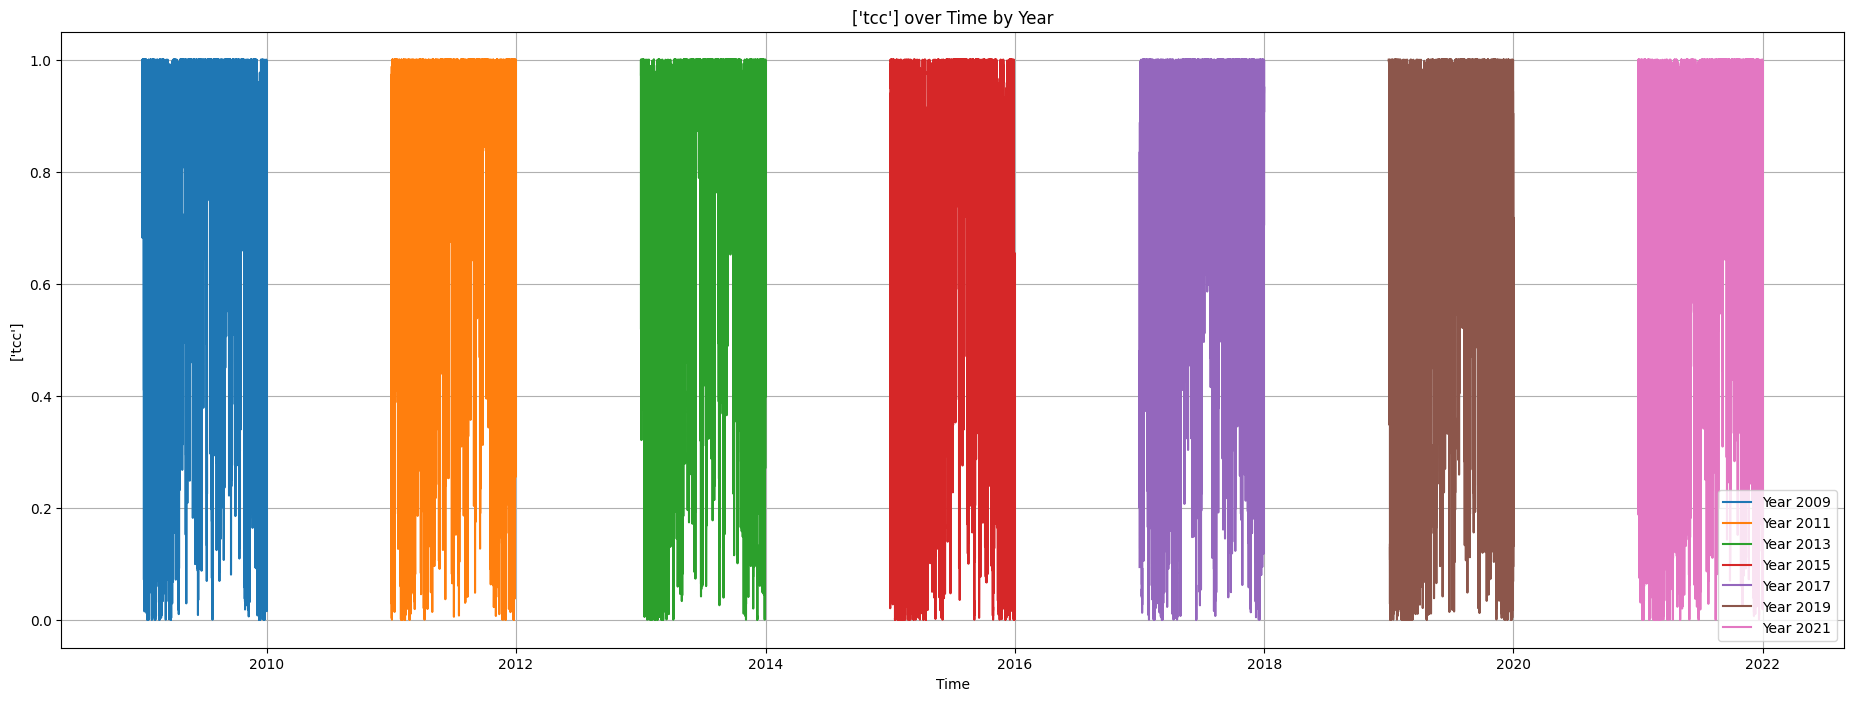

In [14]:
plot_target_by_year(cds_df, time_column, target_vars)

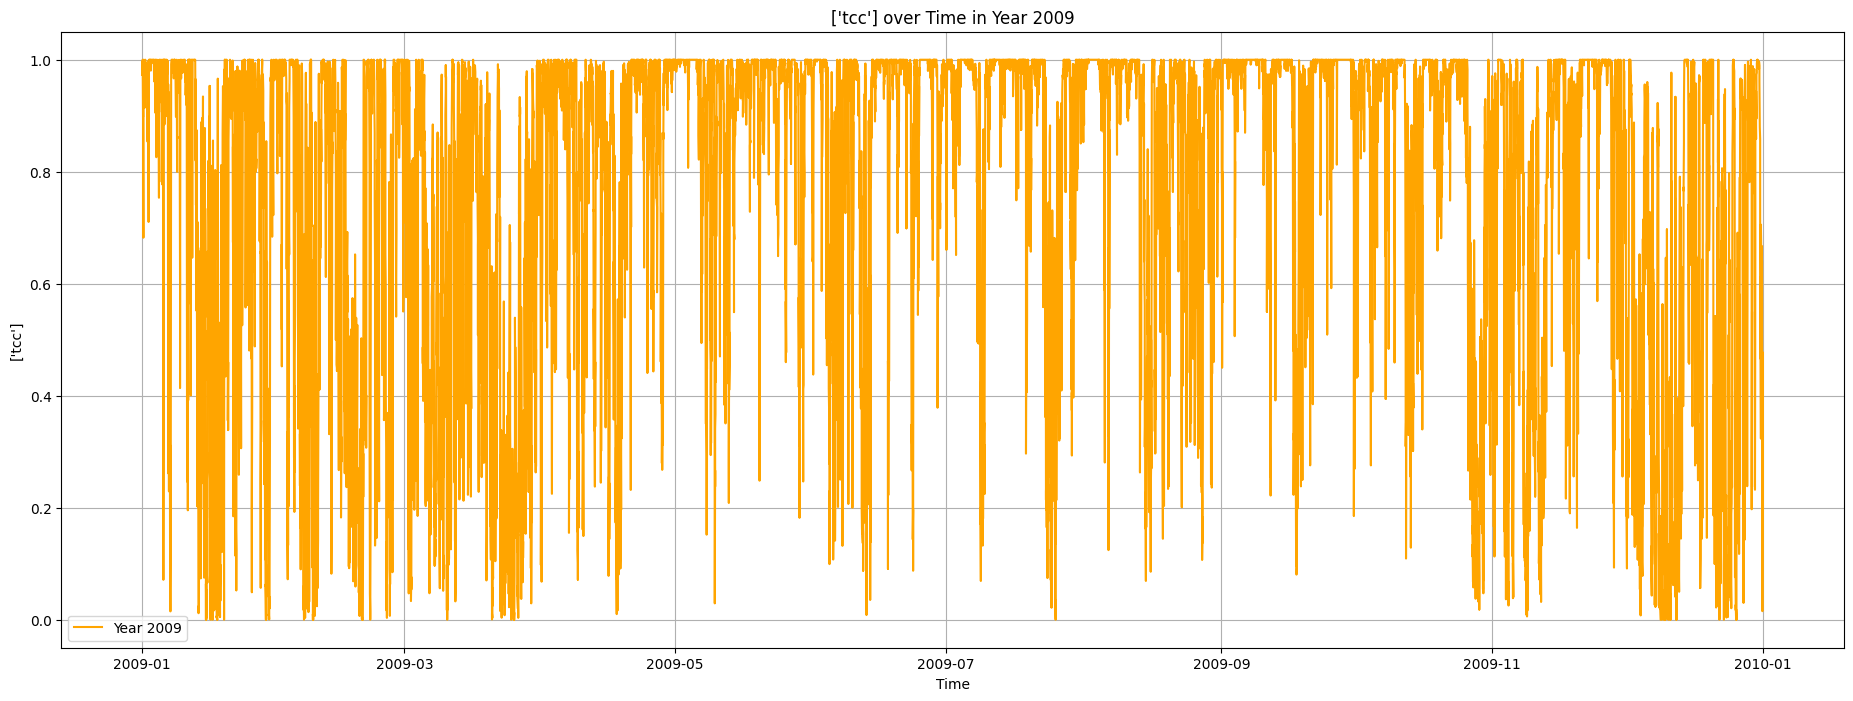

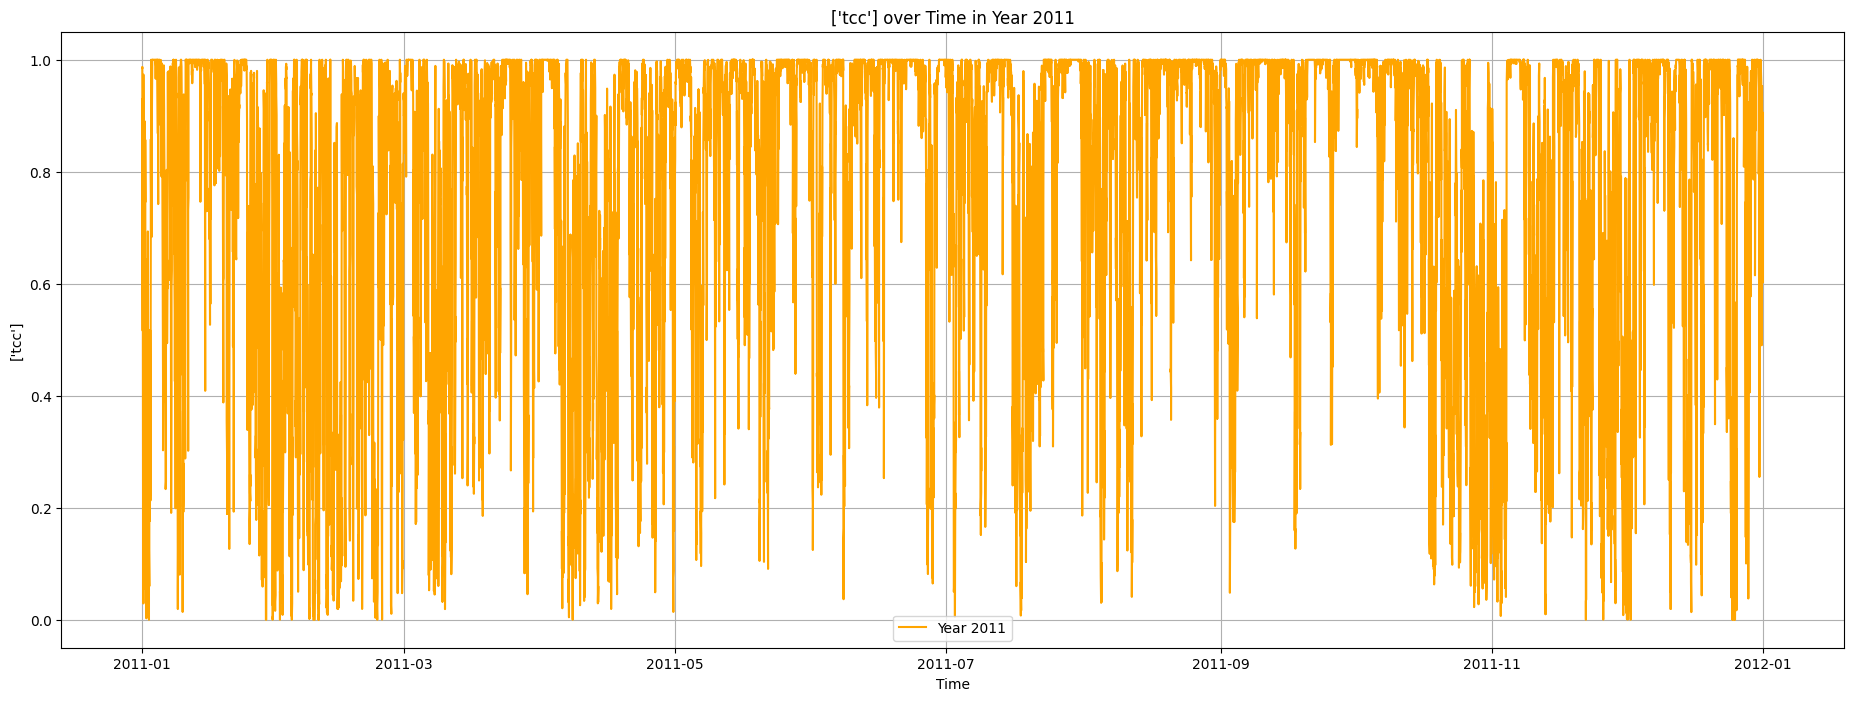

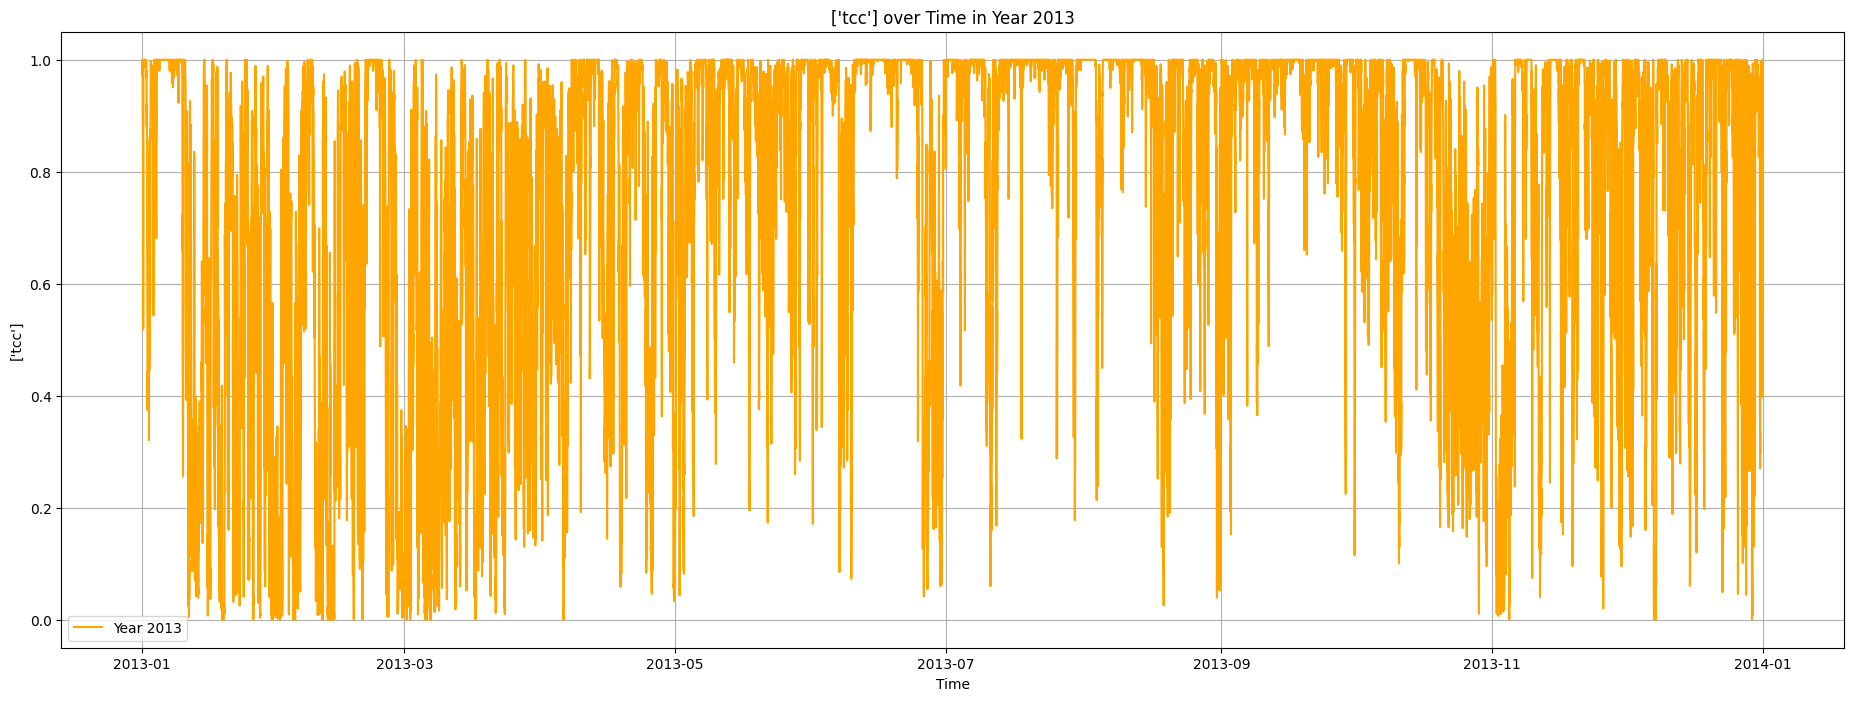

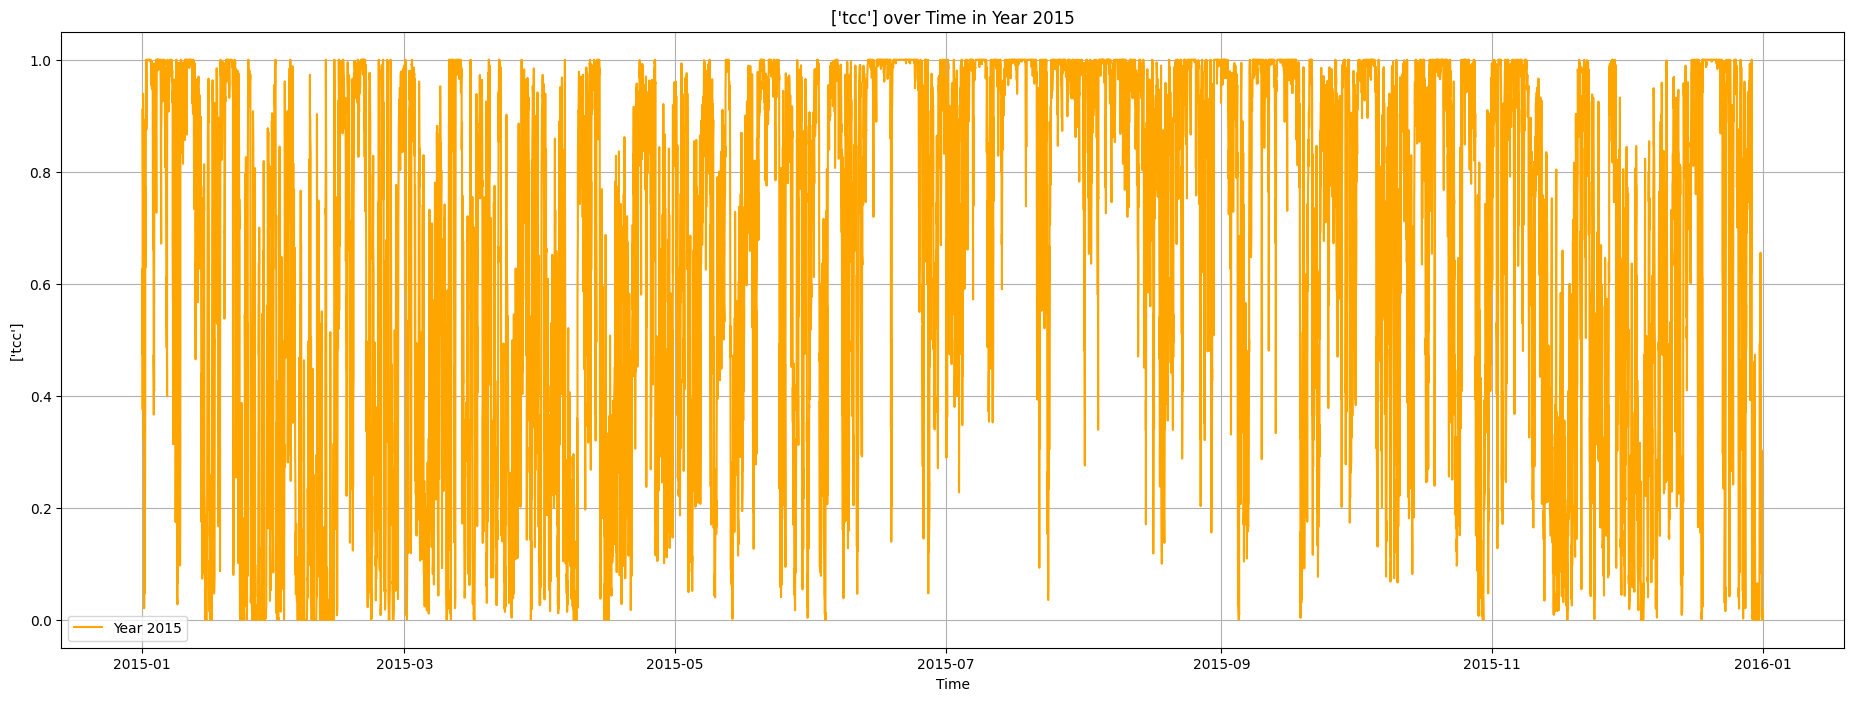

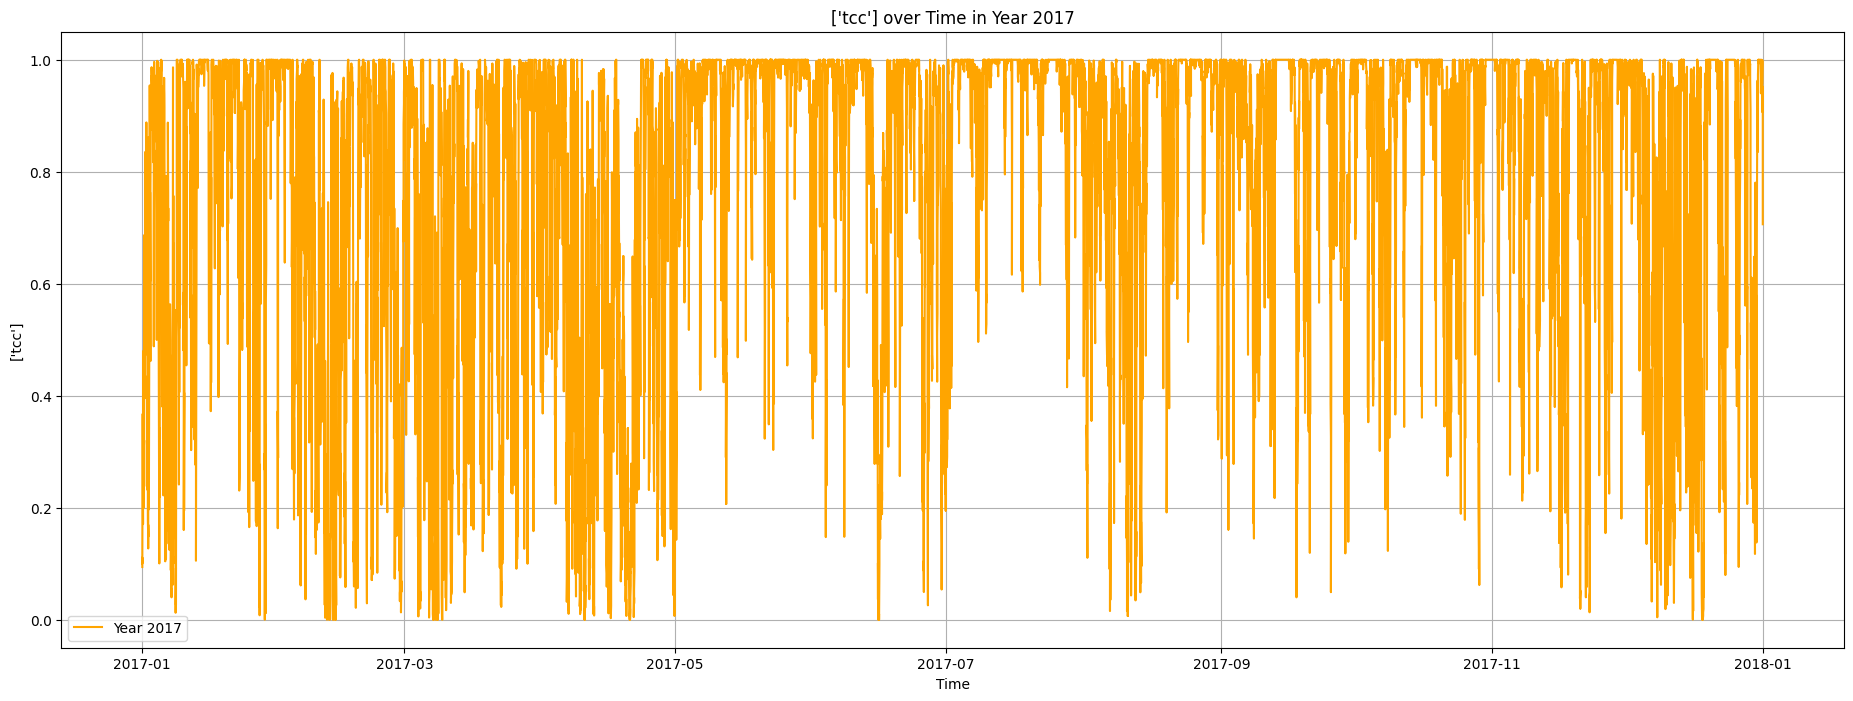

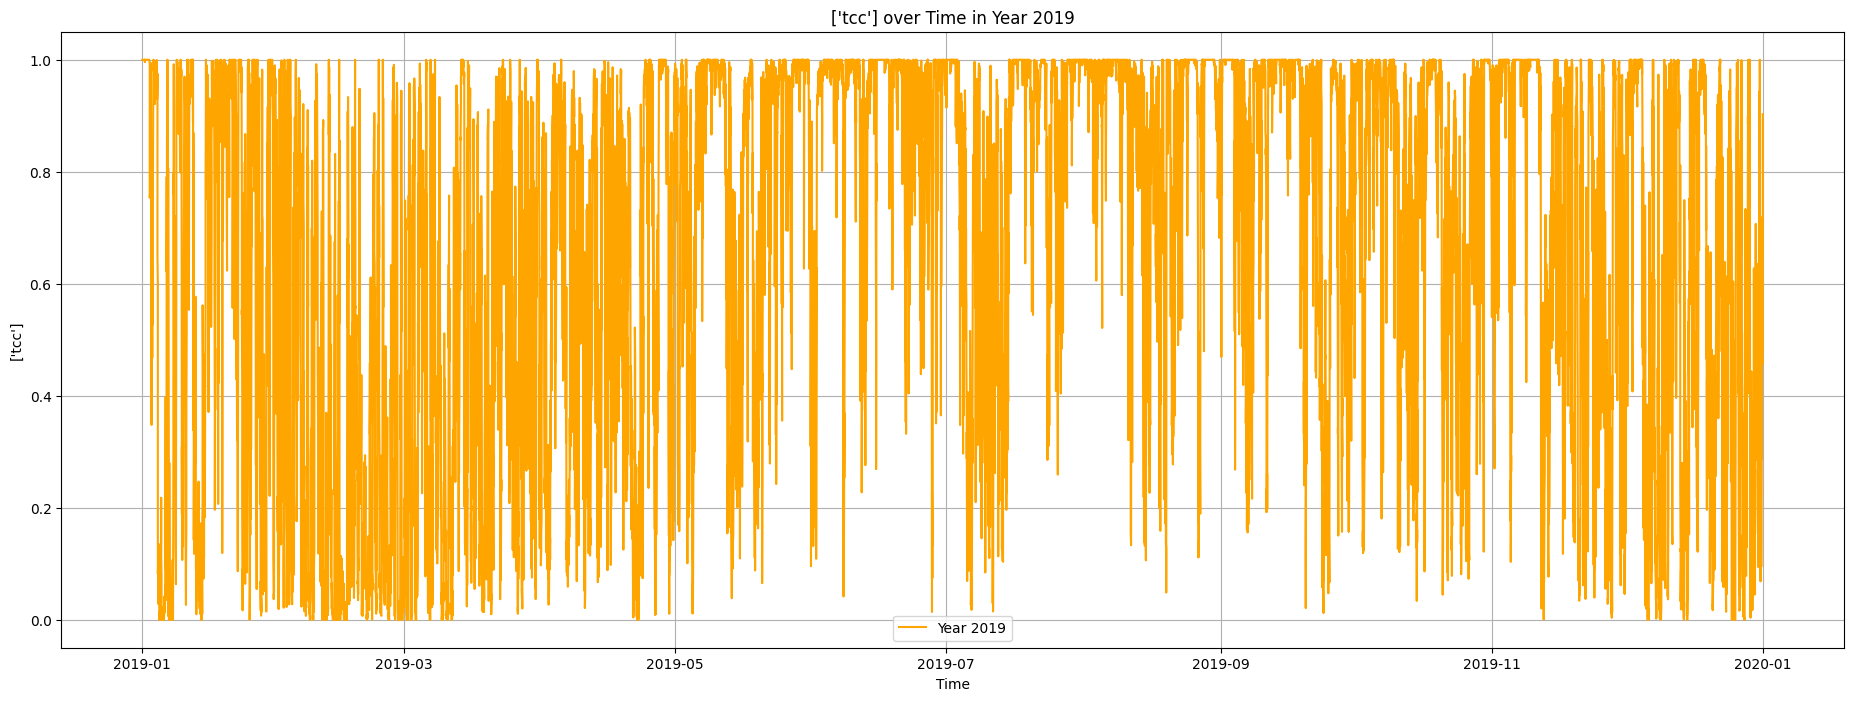

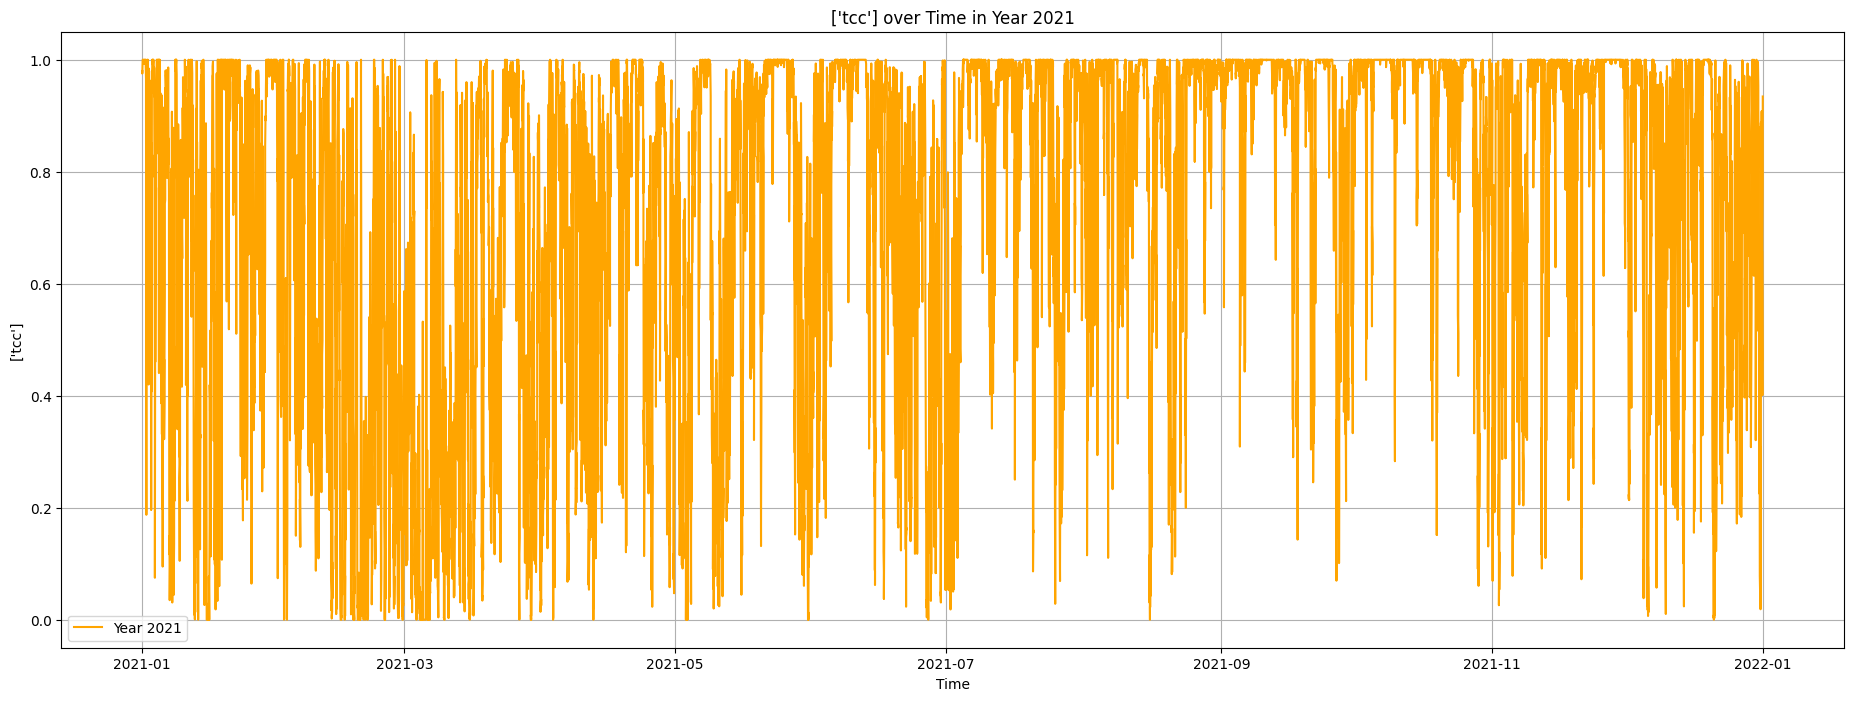

In [15]:
plot_target_by_year(cds_df, time_column, target_vars, same_graph=False)

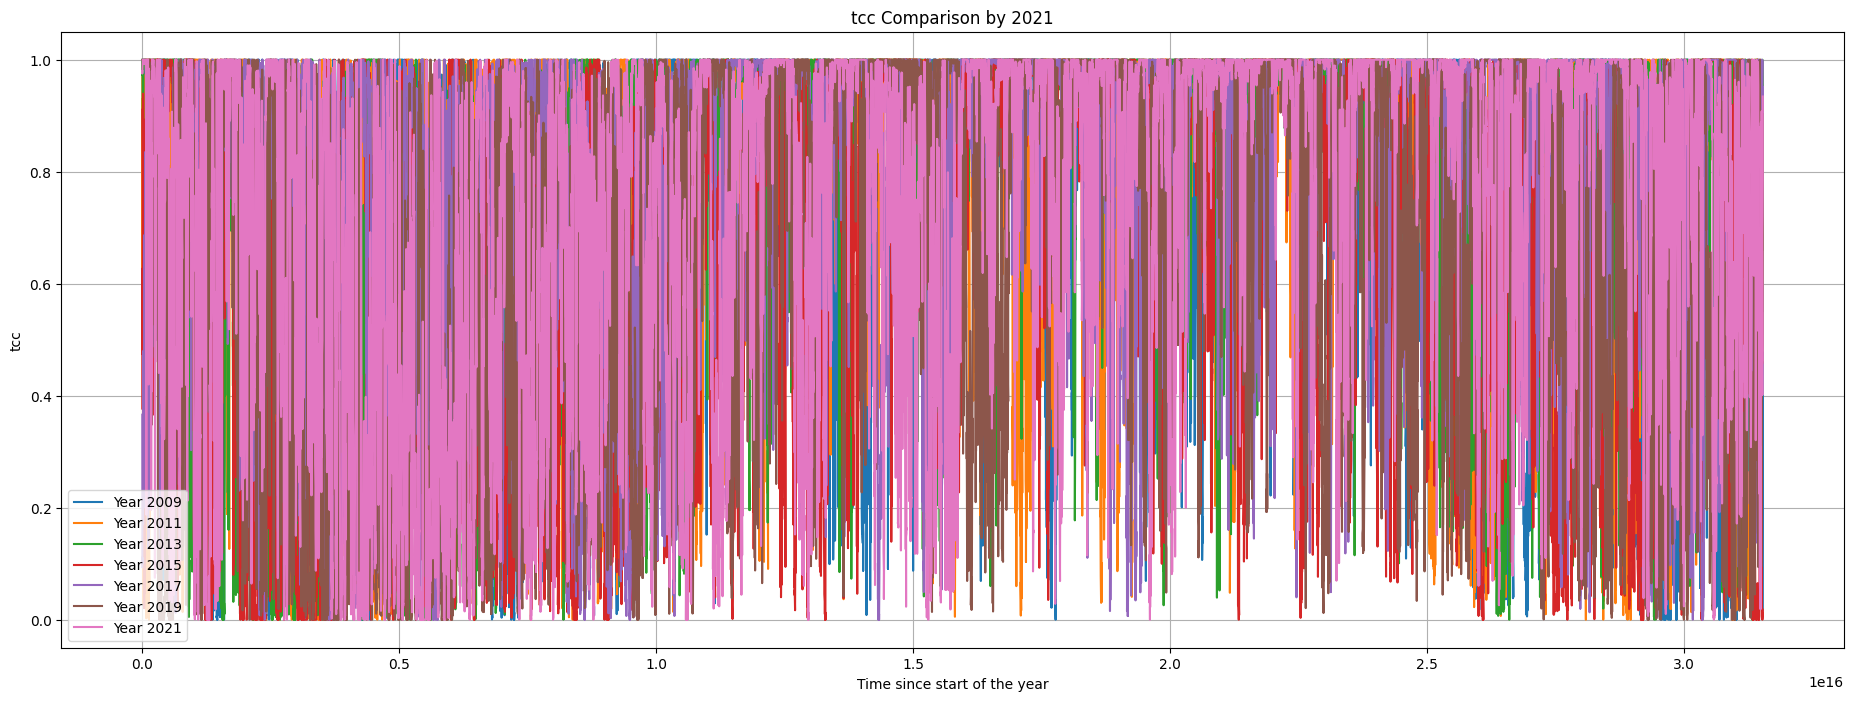

In [16]:
plot_target_comparison(cds_df, 'time', target_vars, 'year', overlap=True)

In [17]:
cds_df = add_cyclical_calendar_features(cds_df, calendar_cycle, time_column)
cds_df

[INFO] Adding cyclical calendar features: ['weekday', 'week', 'month']


,time,latitude,longitude,tcc,year,period,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos
0,2013-01-01 00:00:00,11.00,106.5,0.973326,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025
1,2013-01-01 00:00:00,10.75,106.5,0.983245,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025
2,2013-01-01 00:00:00,10.50,106.5,1.000000,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025
3,2013-01-01 02:00:00,11.00,106.5,0.966154,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025
4,2013-01-01 02:00:00,10.75,106.5,0.945890,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
91975,2021-12-31 20:00:00,10.75,106.5,0.556361,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000
91976,2021-12-31 20:00:00,10.50,106.5,0.683808,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000
91977,2021-12-31 22:00:00,11.00,106.5,0.786596,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000
91978,2021-12-31 22:00:00,10.75,106.5,0.882380,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000


In [18]:
cds_df = factorize_column(cds_df, column=time_column, new_column='time_idx')
cds_df

[INFO] Factorized column 'time' into 'time_idx' with incrementing count.


,time,latitude,longitude,tcc,year,period,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,time_idx
0,2013-01-01 00:00:00,11.00,106.5,0.973326,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
1,2013-01-01 00:00:00,10.75,106.5,0.983245,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
2,2013-01-01 00:00:00,10.50,106.5,1.000000,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
3,2013-01-01 02:00:00,11.00,106.5,0.966154,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
4,2013-01-01 02:00:00,10.75,106.5,0.945890,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91975,2021-12-31 20:00:00,10.75,106.5,0.556361,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91976,2021-12-31 20:00:00,10.50,106.5,0.683808,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91977,2021-12-31 22:00:00,11.00,106.5,0.786596,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659
91978,2021-12-31 22:00:00,10.75,106.5,0.882380,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659


In [19]:
cds_df = drop_columns(cds_df, [time_column])
cds_df

[INFO] Dropped columns: ['time']


,latitude,longitude,tcc,year,period,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,time_idx
0,11.00,106.5,0.973326,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
1,10.75,106.5,0.983245,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
2,10.50,106.5,1.000000,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
3,11.00,106.5,0.966154,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
4,10.75,106.5,0.945890,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91975,10.75,106.5,0.556361,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91976,10.50,106.5,0.683808,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91977,11.00,106.5,0.786596,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659
91978,10.75,106.5,0.882380,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659


In [20]:
cds_df = convert_columns_to_string(cds_df, ["latitude", "longitude"])
cds_df

[INFO] Converted column 'latitude' to string.
[INFO] Converted column 'longitude' to string.


,latitude,longitude,tcc,year,period,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,time_idx
0,11.0,106.5,0.973326,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
1,10.75,106.5,0.983245,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
2,10.5,106.5,1.000000,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
3,11.0,106.5,0.966154,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
4,10.75,106.5,0.945890,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91975,10.75,106.5,0.556361,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91976,10.5,106.5,0.683808,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91977,11.0,106.5,0.786596,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659
91978,10.75,106.5,0.882380,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659


In [21]:
consistency_check(cds_df)
cds_df

[DEBUG] No missing time indices detected.


,latitude,longitude,tcc,year,period,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,time_idx
0,11.0,106.5,0.973326,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
1,10.75,106.5,0.983245,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
2,10.5,106.5,1.000000,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
3,11.0,106.5,0.966154,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
4,10.75,106.5,0.945890,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91975,10.75,106.5,0.556361,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91976,10.5,106.5,0.683808,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91977,11.0,106.5,0.786596,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659
91978,10.75,106.5,0.882380,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659


In [22]:
df = cds_df
df

,latitude,longitude,tcc,year,period,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos,time_idx
0,11.0,106.5,0.973326,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
1,10.75,106.5,0.983245,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
2,10.5,106.5,1.000000,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,0
3,11.0,106.5,0.966154,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
4,10.75,106.5,0.945890,2013,2013,0.781831,0.623490,0.120537,0.992709,5.000000e-01,0.866025,1
...,...,...,...,...,...,...,...,...,...,...,...,...
91975,10.75,106.5,0.556361,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91976,10.5,106.5,0.683808,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30658
91977,11.0,106.5,0.786596,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659
91978,10.75,106.5,0.882380,2021,2021,-0.433884,-0.900969,0.0,1.0,-2.449294e-16,1.000000,30659


[INFO] PLotting cyclical features: dict_keys(['weekday', 'week', 'month'])
[DEBUG] Plotting weekday feature on subplot index 1
[DEBUG] Plotting week feature on subplot index 2
[DEBUG] Plotting month feature on subplot index 3


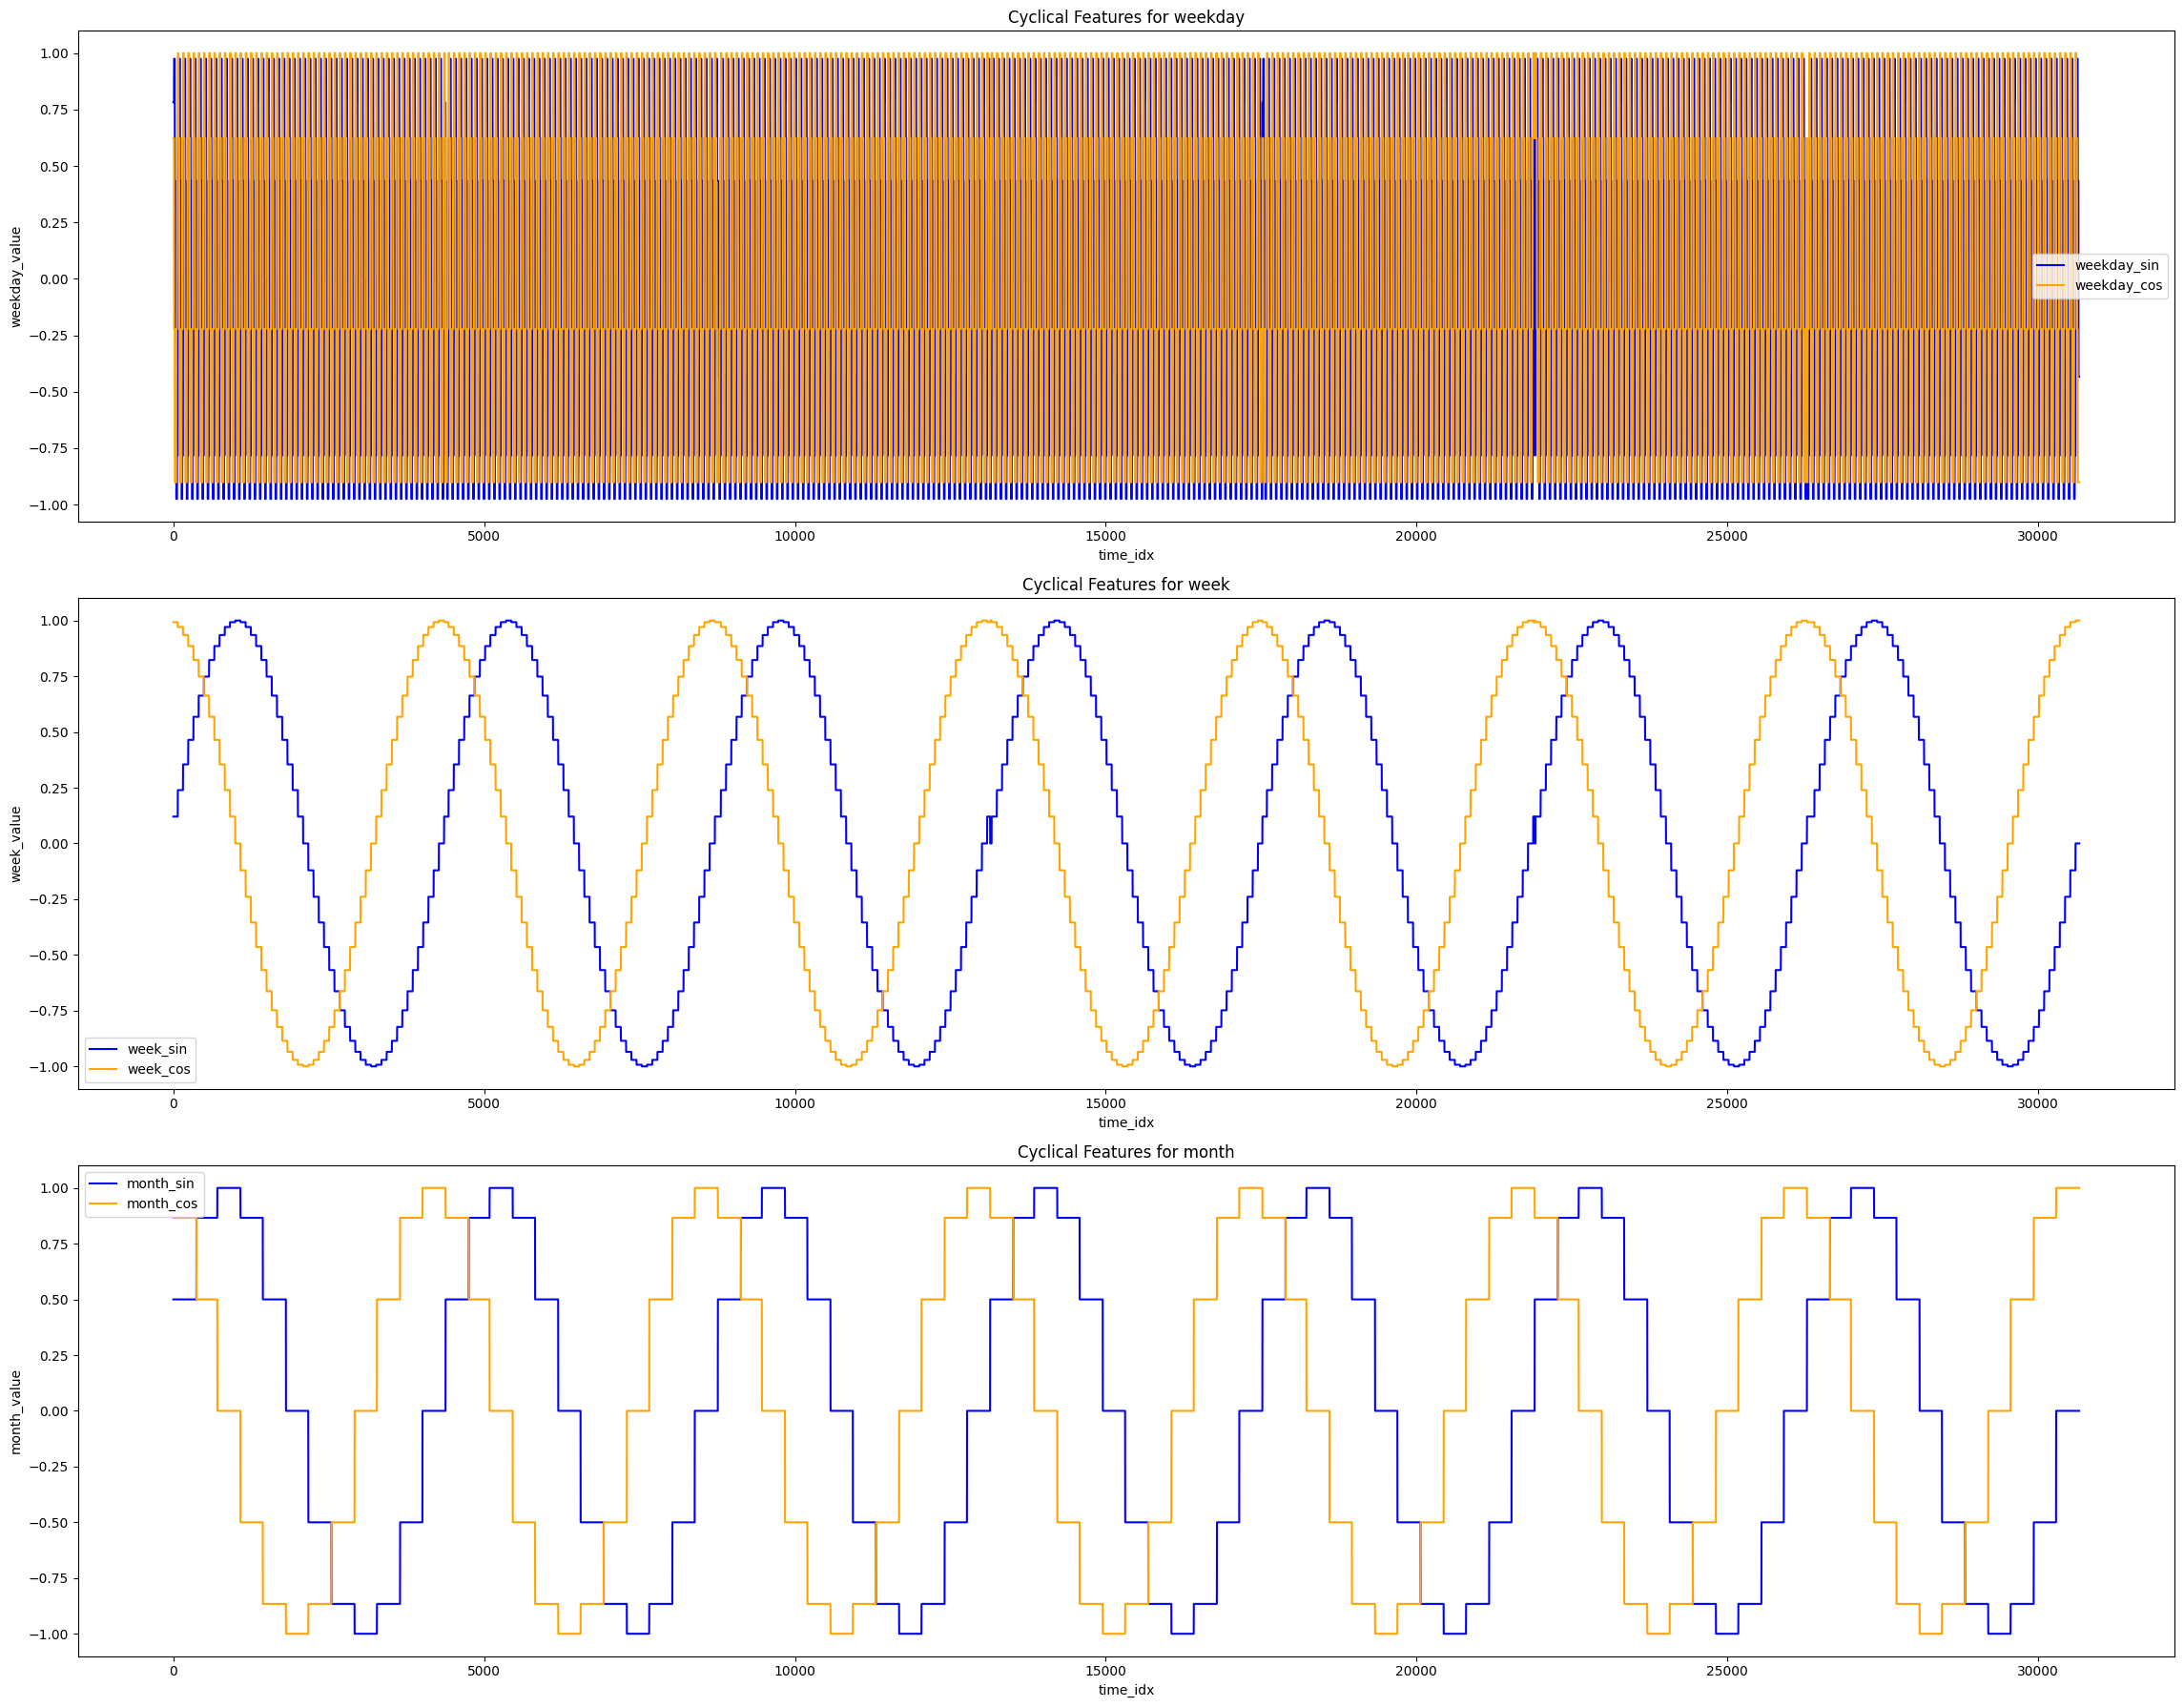

In [23]:
plot_cyclical_features(cds_df, time_column="time_idx", feature_prefixes=data_config['calendar_cycle'].keys())

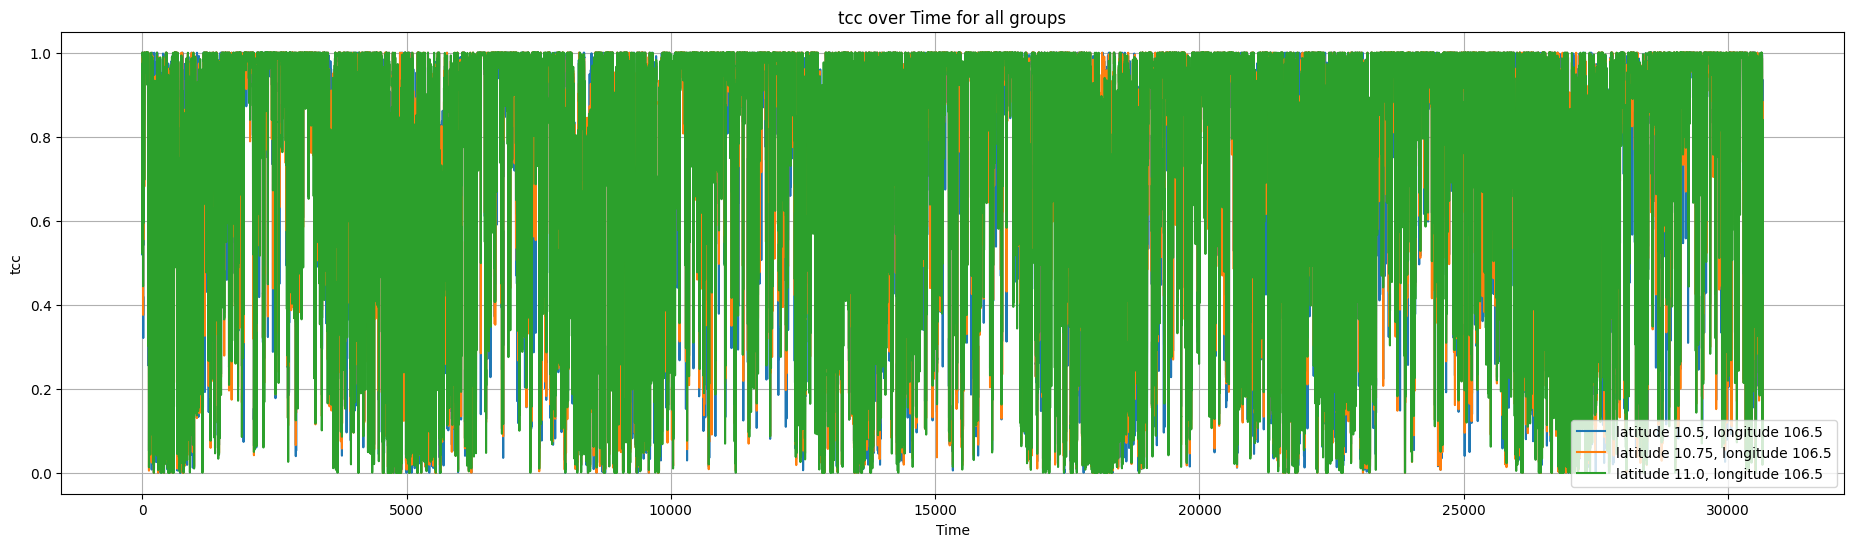

In [24]:
plot_target(cds_df, time_column="time_idx", targets=target_vars, group_by=['latitude', 'longitude'])

### Create TimeSeriesDatasets

In [25]:
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting import TimeSeriesDataSet

In [26]:
max_encoder_length = time_series_config['max_encoder_length']
max_prediction_length = time_series_config['max_prediction_length']
min_prediction_length = time_series_config['min_prediction_length']
min_encoder_length = time_series_config['min_encoder_length']
targets = time_series_config['target_vars']
groups = time_series_config['groups']
static_categoricals = time_series_config['static_categoricals']
time_varying_known_reals = time_series_config['time_varying_known_reals']
lags = time_series_config['lags']
allow_missing_timesteps = time_series_config['allow_missing_timesteps']
add_relative_time_idx = time_series_config['add_relative_time_idx']
add_target_scales = time_series_config['add_target_scales']
add_encoder_length = time_series_config['add_encoder_length']

In [27]:
common_params = {
    'time_idx': "time_idx",
    'target': targets[0] if len(targets) == 1 else targets,
    'group_ids': groups,
    'min_encoder_length': min_encoder_length,
    'max_encoder_length': max_encoder_length,
    'min_prediction_length': min_prediction_length,
    'max_prediction_length': max_prediction_length,
    'static_categoricals': static_categoricals,
    'time_varying_known_reals': time_varying_known_reals,
    'time_varying_unknown_reals': targets,
    'lags': lags,
    'target_normalizer': GroupNormalizer(groups=groups, transformation="softplus") if len(targets) == 1 else MultiNormalizer([GroupNormalizer(groups=groups)] * len(targets)),
    'allow_missing_timesteps': allow_missing_timesteps,
    'add_relative_time_idx': add_relative_time_idx,
    'add_target_scales': add_target_scales,
    'add_encoder_length': add_encoder_length,
}

In [28]:
training_cutoff = df["time_idx"].max() - max_prediction_length
print(f'[DEBUG] Training cutoff at time_idx: {training_cutoff}')

[DEBUG] Training cutoff at time_idx: 30294


In [29]:
training_df = df[df["time_idx"] <= training_cutoff]
print(f'[DEBUG] training_df size: {len(training_df)}')

[DEBUG] training_df size: 90885


In [30]:
training_dataset = TimeSeriesDataSet(training_df, **common_params)

In [31]:
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    df,
    predict=True,
    stop_randomization=True
)

### Dataloader

In [32]:
from tools.data_process import dataloader

In [33]:
batch_size = training_config['batch_size']
num_workers = training_config['num_workers']

In [34]:
train_dataloader = dataloader(training_dataset, train=True, batch_size=batch_size, num_workers=num_workers)
val_dataloader = dataloader(validation_dataset, train=False, batch_size=batch_size, num_workers=num_workers)

[INFO] Creating DataLoader for training...
[INFO] Creating DataLoader for validation...


## Train Pipeline

In [35]:
training_dir, checkpoint_dir, logs_dir, inference_dir = create_training_directory(log_config)

#### Hyperparam Tuning

In [36]:
import os
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from tools.hyperparam_tuning import tune_hyperparameters
from tools.train import initialize_model, create_trainer
from tools.eval import evaluate_pipeline
from utils.file_utils import dump_config

In [37]:
best_params = {}
# best_params = tune_hyperparameters(train_dataloader, val_dataloader, logs_dir, config, trainer_func=create_trainer, model_func=initialize_model)

#### Training

In [38]:
dump_config(config, os.path.join(logs_dir, "config.yaml"))

In [ ]:
tft = initialize_model(train_dataloader, best_params, config['training'], target_count=len(config['time_series']['target_vars']))

In [40]:
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=config['checkpoint']['checkpoint_filename'],
    save_top_k=config['checkpoint']['save_top_k'],
    every_n_epochs=config['checkpoint']['every_n_epochs'],
    monitor=config['checkpoint']['monitor'],
    mode=config['checkpoint']['mode'],
    save_last=config['checkpoint']['save_last'],
    save_weights_only=config['checkpoint']['save_weights_only'],
    verbose=config['checkpoint']['verbose']
)
early_stop_callback = EarlyStopping(monitor=checkpoint_config["monitor"], min_delta=config['training']['early_stop_min_delta'], patience=config['training']['early_stop_patience'], verbose=False, mode=checkpoint_config["mode"])
lr_logger = LearningRateMonitor()
progress_bar = TQDMProgressBar(refresh_rate=1)
logger = TensorBoardLogger(save_dir=logs_dir, name="training_logs")

In [41]:
trainer = create_trainer(config, logger, checkpoint_callback, early_stop_callback, lr_logger, progress_bar)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[INFO] Training device: gpu


In [42]:
trainer.fit(tft, train_dataloader, val_dataloader) 

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ./results/trainings/20240802_062424/logs/training_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 10     | train
3  | prescalers                         | ModuleDict    

Epoch 11: 100%|██████████| 50/50 [00:17<00:00,  2.78it/s, v_num=0, train_loss_step=0.102, val_loss=0.116, train_loss_epoch=0.108] 


In [43]:
best_model_path = checkpoint_callback.best_model_path

[INFO] Loading model from /home/phatvo/phananh/weather_forecast/results/trainings/20240802_062424/checkpoints/checkpoint_epoch=004_val_loss=0.1164.ckpt


/home/phatvo/phananh/weather_forecast/tft_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/phatvo/phananh/weather_forecast/tft_env/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[INFO] Model loaded successfully.
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.16it/s]
[INFO] Baseline model validation results: [{'val_loss': 0.36305394768714905}]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[INFO] TFT model validation results: [{'val_loss': 0.4966278076171875, 'val_SMAPE': 0.5688039660453796, 'val_MAE': 0.39869093894958496, 'val_RMSE': 0.46233120560646057, 'val_MAPE': 35842.40234375}]
[INFO] Plotting result...


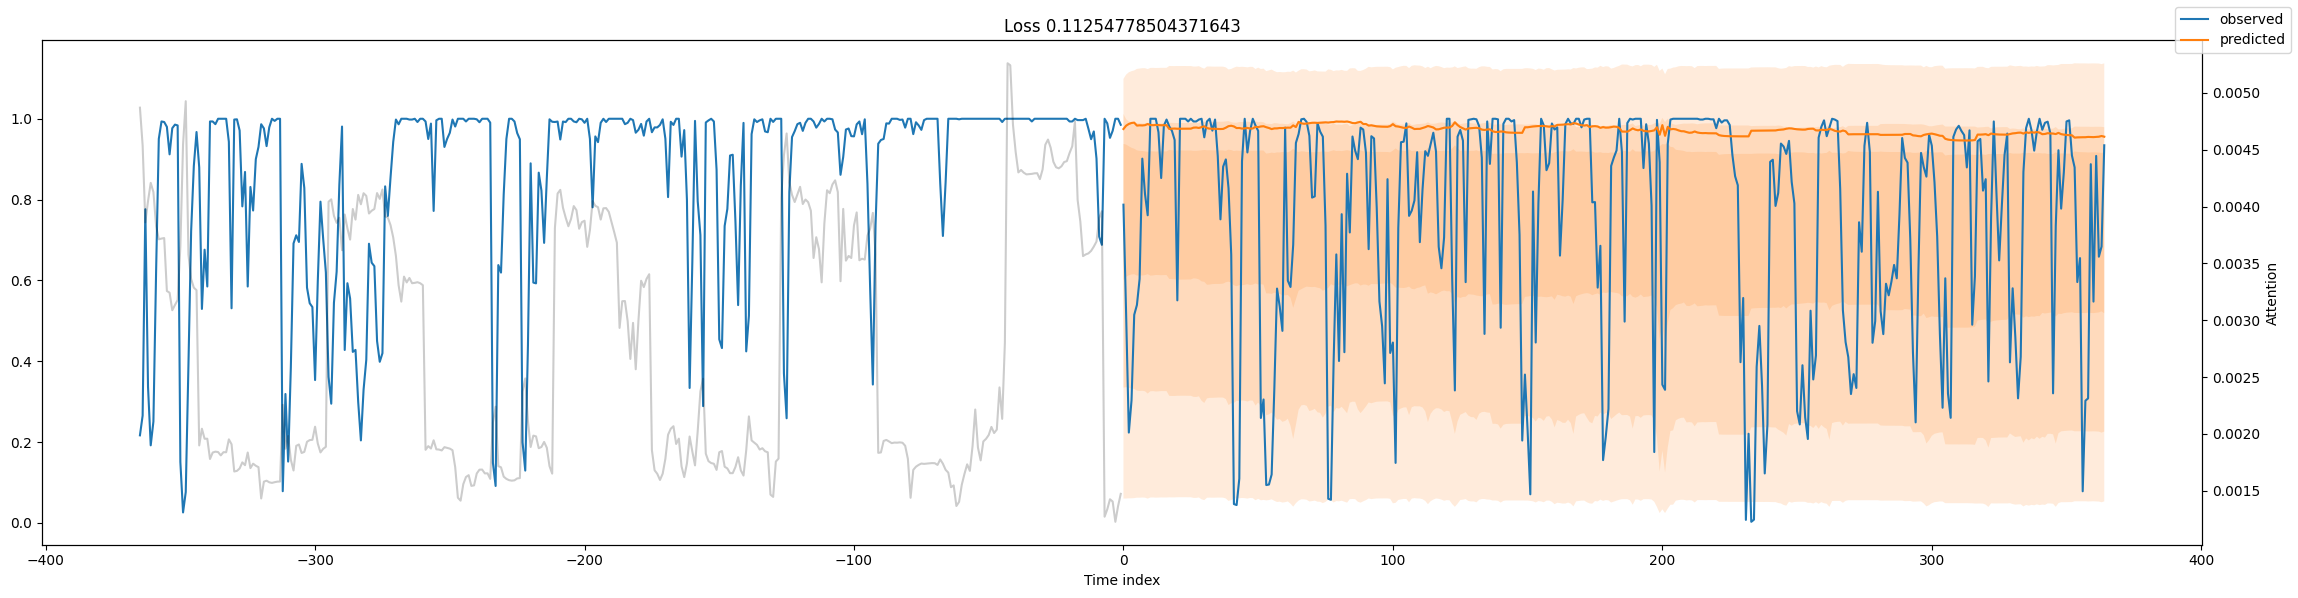

[INFO] Plots saved to ./results/trainings/20240802_062424/inferences
[INFO] Model predictions plotted successfully
[INFO] Interpreting model predictions...
[DEBUG] Excluded plots:  {'tcc_lagged_by_360', 'tcc_lagged_by_4379'}


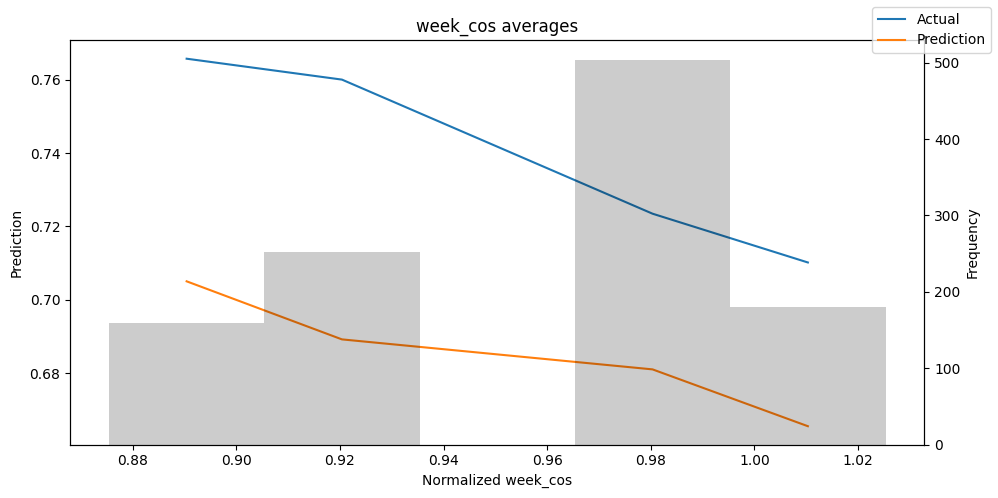

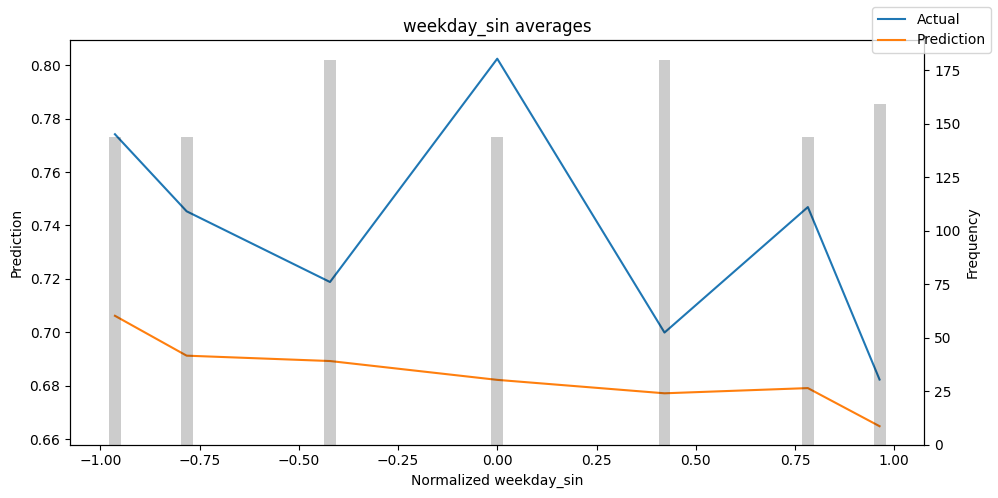

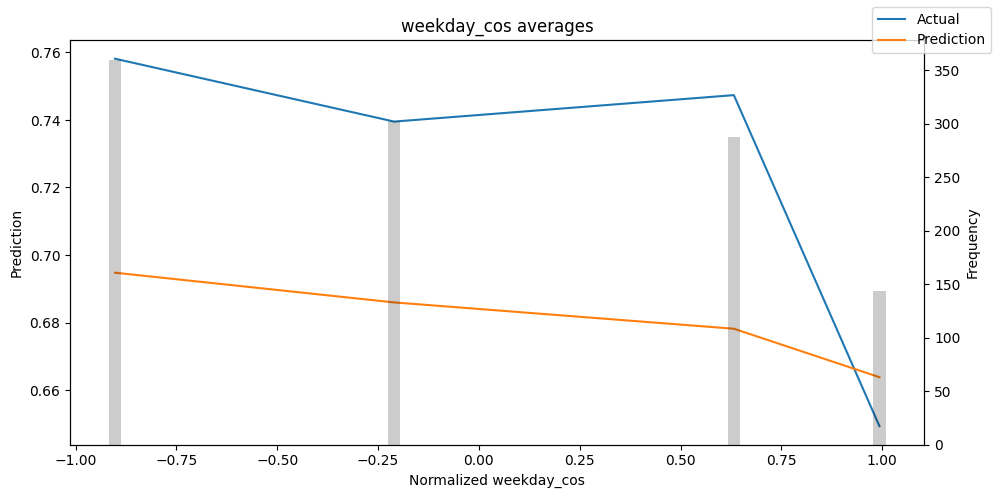

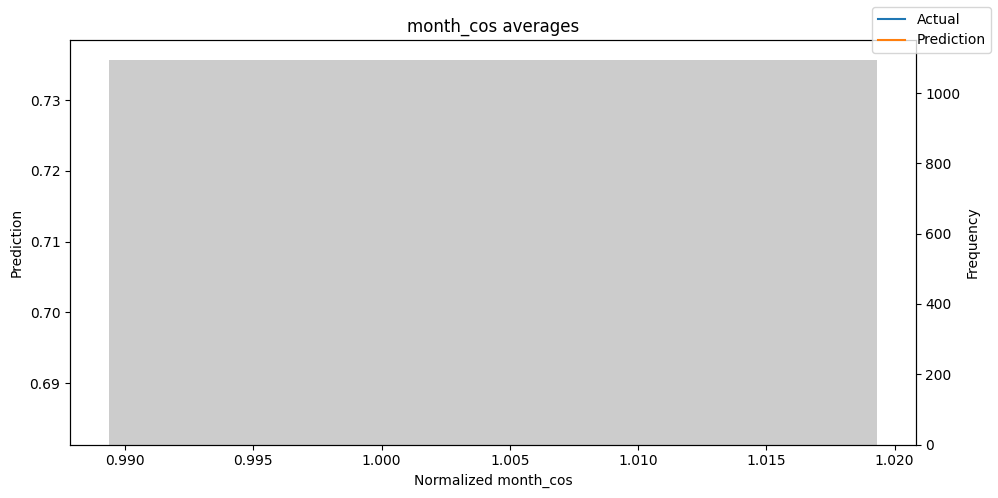

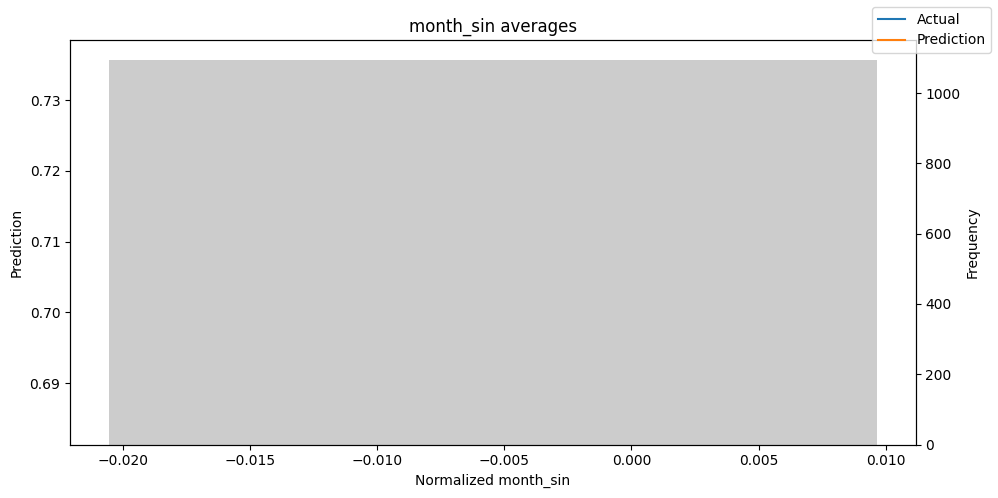

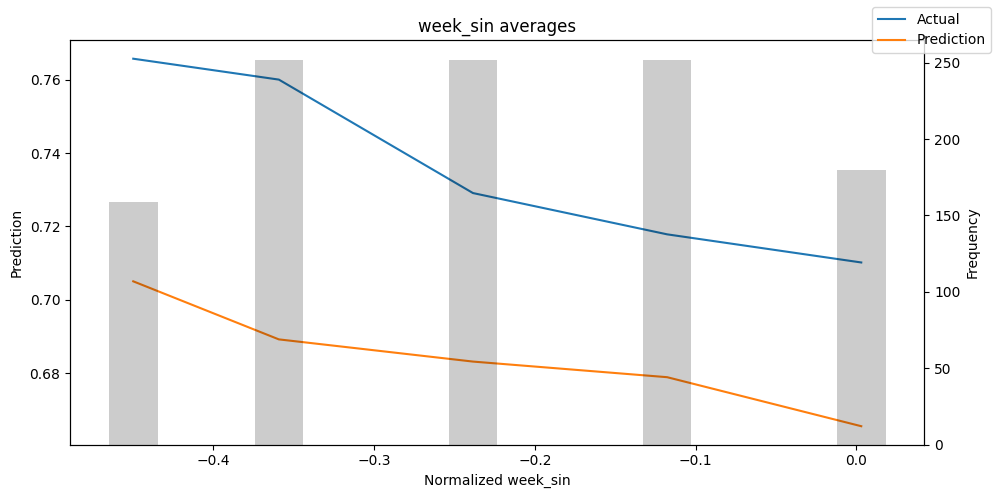

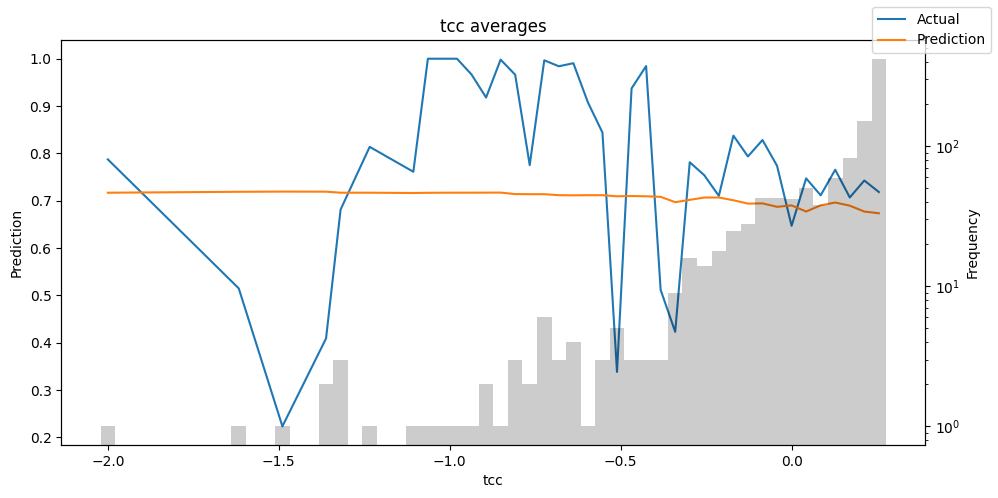

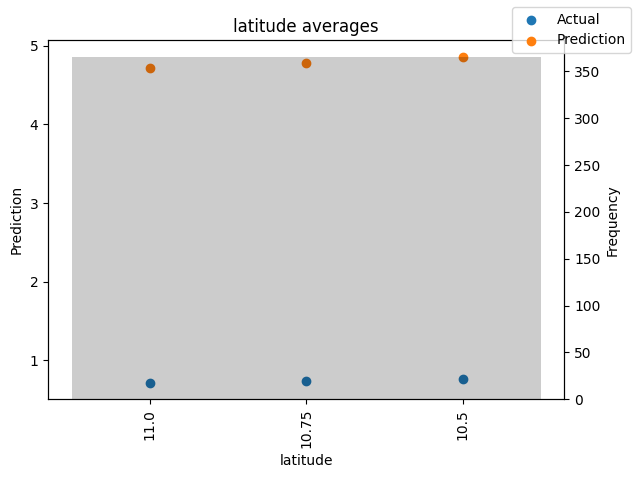

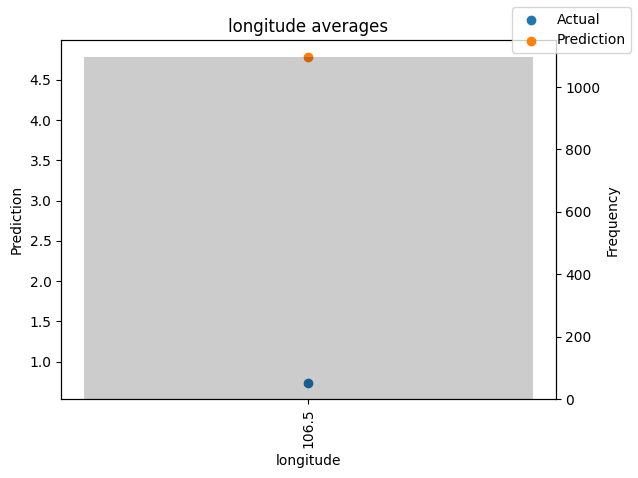

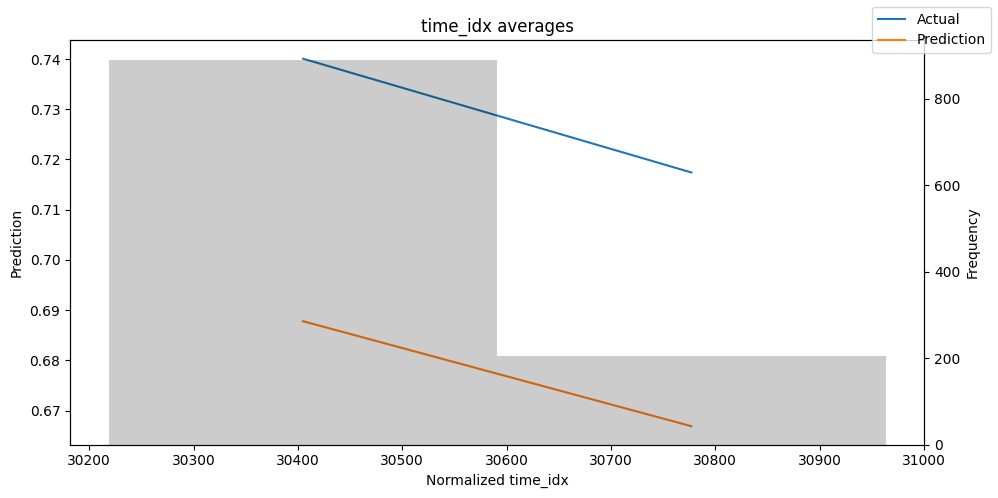

[INFO] Interpretation plots saved to ./results/trainings/20240802_062424/inferences
[INFO] Model predictions interpreted successfully


In [44]:
evaluate_pipeline(best_model_path, val_dataloader, inference_dir, config=config, show_future_observed=True, add_loss_to_title=True, show=True)

## Evaluation Pipeline

### Initialization

In [ ]:
from pytorch_forecasting import Baseline
from utils.file_utils import load_model
from utils.data_visualization import plot_predictions, interpret_model_predictions
from tools.eval import evaluate_loss, perform_inference

In [ ]:
evaluation_dir, logs_dir, inference_dir = create_evaluation_directory(log_config)

In [ ]:
config_path = 'results/trainings/20240731_032655_hid32hidc16/logs/config.yaml'
model_path = 'results/trainings/20240731_032655_hid32hidc16/best_model.ckpt'
data_root = 'data/samples/testing/*.nc'

### Data Pipeline

#### Preprocessing

In [ ]:
from datasets.cds.data_handling import filter_dataframe
from utils.dataset_utils import get_combined_dataset
from utils.dataframe_utils import convert_to_datetime, factorize_column, drop_columns, check_and_handle_missing_values, consistency_check, convert_columns_to_string, add_cyclic_features, save_to_csv, convert_to_dataframe

In [ ]:
target_vars = ['tcc']
time_column = 'time'

In [ ]:
ds = get_combined_dataset(data_root)
df = convert_to_dataframe(ds, variables=target_vars)
cds_df = convert_to_datetime(df, column=time_column)
cds_df

In [ ]:
lat_range = [10.5, 10.5]
long_range = [106.5, 106.5]
time_range = []
canlemdar_cycle = {"day": 365, "weekday": 7, "week": 52, "month": 12} # {"hour": 12, "day": 365, "weekday": 7, "week": 52, "month": 12, "year": 1}

In [ ]:
cds_df = filter_dataframe(cds_df, lat_range, long_range, time_range=time_range)
cds_df

In [ ]:
cds_df = check_and_handle_missing_values(cds_df, drop=True)
cds_df = add_cyclical_calendar_features(cds_df, calendar_cycle, time_column)
cds_df = factorize_column(cds_df, column=time_column, new_column='time_idx')
cds_df = drop_columns(cds_df, [time_column])

In [ ]:
# Group by latitude and longitude
grouped = cds_df.groupby(['latitude', 'longitude'])

# Plot tcc over time for each group
for (lat, lon), group in grouped:
    plt.figure(figsize=(23, 8))
    plt.plot(group['time_idx'], group['tcc'])
    plt.title(f'Total Cloud Cover at Latitude {lat} and Longitude {lon}')
    plt.xlabel('Time')
    plt.ylabel('Total Cloud Cover (tcc)')
    plt.grid(True)
    plt.show()

In [ ]:
cds_df = convert_columns_to_string(cds_df, ["latitude", "longitude"])
consistency_check(cds_df)
cds_df

In [ ]:
df = cds_df
df

#### Create TimeSeriesDatasets

In [ ]:
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting import TimeSeriesDataSet

In [ ]:
groups = ["latitude", "longitude"]

max_encoder_length = 365
min_encoder_length = 182
max_prediction_length = 365
min_prediction_length = 12

In [ ]:
common_params = {
    'time_idx': "time_idx",
    'target': target_vars[0] if len(target_vars) == 1 else target_vars,
    'group_ids': groups,
    'min_encoder_length': min_encoder_length,
    'max_encoder_length': max_encoder_length,
    'min_prediction_length': min_prediction_length,
    'max_prediction_length': max_prediction_length,
    'static_categoricals': ["latitude", "longitude"],
    'time_varying_known_reals': ["time_idx", "sin_hour", "cos_hour", "sin_day_of_week", "cos_day_of_week", "sin_month", "cos_month", "sin_year", "cos_year"],
    'time_varying_unknown_reals': target_vars,
    'lags': {'tcc':[84, 4379]},
    'target_normalizer': GroupNormalizer(groups=groups, transformation="softplus") if len(target_vars) == 1 else MultiNormalizer([GroupNormalizer(groups=groups)] * len(target_vars)),
    'allow_missing_timesteps': False,
    'add_relative_time_idx': True,
    'add_target_scales': True,
    'add_encoder_length': True,
}

In [ ]:
eval_dataset = TimeSeriesDataSet(df, **common_params, predict_mode=True, stop_randomization=True)

#### Dataloader

In [ ]:
eval_dataloader = dataloader(validation_dataset, train=False, batch_size=batch_size, num_workers=num_workers)

### Evaluating

In [ ]:
model = load_model(model_path)
# mode = load_model(best_model_path)

In [ ]:
evaluate_loss(val_dataloader=eval_dataloader, model=Baseline, model_name="Baseline")
evaluate_loss(val_dataloader=eval_dataloader, model=model, model_name="TFT")

In [ ]:
predictions = perform_inference(model, eval_dataloader, mode='raw', return_index=True, return_x=True)

In [ ]:
interpret_model_predictions(model, prediction=predictions, save_dir=inference_dir, model_name="tft", lags=config['time_series']['lags'], show=True)

In [ ]:
plot_predictions(predictions, model=model, save_dir=inference_dir, show_future_observed=True, add_loss_to_title=True, show=True)